In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
from scipy.stats import norm
import scipy.integrate as integrate

import gym
from gym import spaces

import random
import itertools as it
from joblib import Parallel, delayed
from toolz import memoize
from contracts import contract
from collections import namedtuple, defaultdict, deque, Counter

import warnings
warnings.filterwarnings("ignore", 
                        message="The objective has been evaluated at this point before.")

from agents import Agent
from mouselab import MouselabEnv
from policies import FixedPlanPolicy, LiederPolicy
from evaluation import *
from distributions import cmax, smax, sample, expectation, Normal, PointMass, SampleDist, Normal, Categorical

In [2]:
import ipyparallel as ipp 
rc = ipp.Client(profile='default', cluster_id='')
ipp.register_joblib_backend()

# Mouselab Environment

In [3]:
ZERO = PointMass(0)

class OldMouselabEnv(gym.Env):
    """MetaMDP for the Mouselab task."""
    
    term_state = '__term_state__'
    def __init__(self, gambles=4, attributes=5, reward=None, cost=0,
                 ground_truth=None, initial_states=None, randomness=1):
        
        self.gambles = gambles # number of gambles
        
        # distribution and number of attributes
        if hasattr(attributes, '__len__'):
            self.outcomes = len(attributes)
            self.dist = np.array(attributes)/np.sum(attributes)
        else:
            self.outcomes = attributes
            self.dist = np.random.dirichlet(np.ones(attributes)*randomness,size=1)[0]
        # reward for the payoffs
        self.reward = reward if reward is not None else Normal(1, 1)
        
        if hasattr(reward, 'sample'):
            self.iid_rewards = True
        else:
            self.iid_rewards = False
            
        self.cost = - abs(cost)
        self.initial_states = initial_states
        self.max = cmax
        self.init = np.array([self.reward,] * (self.gambles*self.outcomes))
        
        if ground_truth is False:
            self.ground_truth = ()
        elif ground_truth is not None:
            self.ground_truth = np.array(ground_truth)
        else:
            self.ground_truth = np.array(list(map(sample, self.init)))
            
        self.sample_term_reward = False
        self.term_action = self.gambles*self.outcomes
        self.reset()
#         self.ground_truth = np.array(ground_truth) if ground_truth is not None else None
#         self.grid = np.arange(self.gambles*self.outcomes).reshape((self.gambles, self.outcomes))
#         self.exact = hasattr(reward, 'vals')
#         if self.exact:
#             assert self.iid_rewards
#             self.max = cmax
#             self.init = np.array([self.reward,] * (self.gambles*self.outcomes))
#         else:
#             # Distributions represented as samples.
#             self.max = smax
#             self.init = np.array([self.reward.to_sampledist(),] * (self.gambles*self.outcomes))

    def _reset(self):
        if self.initial_states:
            self.init = random.choice(self.initial_states)
        self._state = self.init
        grid = np.array(self._state).reshape(self.gambles,self.outcomes)
        self.mus = [expectation(np.sum(self.dist*grid[g])) for g in range(self.gambles)]
        # todo: include max_mu
        # tmp: Works only for Normal
        self.vars = np.sum(self.dist**2*reward.sigma**2)*np.ones(self.gambles)
        return self.features(self._state)

    def _step(self, action):
#         print('step ' + str(action))
        if self._state is self.term_state:
            assert 0, 'state is terminal'
            # return None, 0, True, {}
        if action == self.term_action:
            # self._state = self.term_state
            if self.sample_term_reward:
                if self.ground_truth is not None:
                    gamble = self.best_gamble()
                    reward = self.ground_truth[gamble].sum()
                else:
                    reward = self.term_reward().sample()
            else:
                reward = self.expected_term_reward()
            self._state = self.term_state
            done = True
        elif not hasattr(self._state[action], 'sample'):  # already observed
#             assert 0, self._state[action]
            reward = 0
            done = False
        else:  # observe a new node
            self._state = self._observe(action)
            reward = self.cost
            done = False
        return self.features(self._state), reward, done, {}

    def _observe(self, action):
#         print('obs ' + str(action))
        if self.ground_truth is not None:
            result = self.ground_truth[action]
        else:
            result = self._state[action].sample()
        s = list(self._state)
        gamble = action // self.outcomes
        option = action % self.outcomes
        self.mus[gamble] += self.dist[option]*(result - reward.expectation())
        self.vars[gamble] = max(0,self.vars[gamble] - self.dist[option]**2*reward.sigma**2)
        s[action] = result
        return tuple(s)

    def actions(self, state=None):
        """Yields actions that can be taken in the given state.

        Actions include observing the value of each unobserved node and terminating.
        """
        state = state if state is not None else self._state
        if state is self.term_state:
            return
        for i, v in enumerate(state):
            if hasattr(v, 'sample'):
                yield i
        yield self.term_action

    def results(self, state, action):
        """Returns a list of possible results of taking action in state.

        Each outcome is (probability, next_state, reward).
        """
        if action == self.term_action:
            # R = self.term_reward()
            # S1 = Categorical([self.term_state])
            # return cross(S1, R)
            yield (1, self.term_state, self.expected_term_reward(state))
        else:
            for r, p in state[action]:
                s1 = list(state)
                s1[action] = r
                yield (p, tuple(s1), self.cost)

    def features(self, state=None):
        state = state if state is not None else self._state
        return state


    def action_features(self, action, state=None):
        state = state if state is not None else self._state
        assert state is not None


        if action == self.term_action:
            return np.array([
                0,
                0,
                0,
                0,
                self.expected_term_reward(state)
            ])

        return np.array([
            self.cost,
            self.myopic_voi(action, state),
            self.vpi_action(action, state),
            self.vpi(state),
            self.expected_term_reward(state)
        ])
    
    def gsample(self,gamble):
        if hasattr(gamble, 'sample'):
            return gamble.sample()
        return gamble
    
    def vpi(self,state=None):
        gambles = [Normal(self.mus[i],np.sqrt(self.vars[i])) for i in range(self.gambles)]
        samples_max = np.amax([[self.gsample(gambles[i]) for i in range(self.gambles)] for _ in range(2500)],1)
        return np.mean(samples_max) - np.max(self.mus)
    
    def vpi2(self,state=None):
        state = state if state is not None else self._state
        grid = np.array(self._state).reshape(self.gambles,self.outcomes)
        gambles = grid.dot(self.dist)
        samples_max = np.amax([[self.gsample(gambles[i]) for i in range(self.gambles)] for _ in range(2500)],1)
        return np.mean(samples_max) - np.max(self.mus)
   
    def vpi_action(self, action, state=None):
        #todo add action check
        state = state if state is not None else self._state
        #E[value if gamble corresponding to action is fully known]
        gamble = action//self.outcomes
        mus_wo_g = np.delete(self.mus,gamble)
        k = np.max(mus_wo_g)
        m = self.mus[gamble]
        s = np.sqrt(self.vars[gamble])
        e_higher = integrate.quad(lambda x: x*norm.pdf(x,m,s), k, np.inf)[0]
        e_val = k*norm.cdf(k,m,s) + e_higher
        return e_val - np.max(self.mus)
    
    #todo edit
    def myopic_voi(self, action, state=None):
        #todo add action check
        state = state if state is not None else self._state
        #E[value if gamble corresponding to action is fully known]
#         print(action)
        gamble = action // self.outcomes
        outcome = action % self.outcomes
        mus_wo_g = np.delete(self.mus,gamble)
        k = np.max(mus_wo_g)
        m = self.mus[gamble]
        s = reward.sigma*self.dist[outcome]
        e_higher = integrate.quad(lambda x: x*norm.pdf(x,m,s), k, np.inf)[0]
        e_val = k*norm.cdf(k,m,s) + e_higher
        return e_val - np.max(self.mus)

    
    def best_gamble(self, state=None):
        state = state if state is not None else self._state
        grid = np.array(state).reshape(self.gambles,self.outcomes)
        best_idx = np.argmax(self.mus)
#         best_gamble = max((self.dist*grid[g] for g in range(self.gambles)), default=ZERO, key=lambda x: sum(map(expectation,x)))
        return grid[best_idx]
    
    
    def term_reward(self, state=None):
        state = state if state is not None else self._state
        assert state is not None
        state_value = self.state_value(state)
        return state_value  
    
    def state_value(self, state=None):
        """A distribution over total rewards after the given node."""
        state = state if state is not None else self._state
        best_gamble = self.dist * self.best_gamble(state)
        return np.sum(best_gamble)   
    
    def expected_term_reward(self, state=None):
        sum_bg = self.term_reward(state)
        if hasattr(sum_bg, 'sample'):
            return sum_bg.expectation()
        return sum_bg

In [4]:
gambles = 4
attributes = [0.24,0.74,0.01,0.01]
reward = Normal(2,1)
cost=0.03
env = OldMouselabEnv(gambles, attributes, reward)

In [5]:
attributes = 4
env = OldMouselabEnv(gambles, attributes, reward, cost, randomness=0.1)

In [6]:
env.action_features(4)

array([-0.03 , -1.   ,  0.231,  0.596,  2.   ])

## Time features

In [7]:
import datetime

In [8]:
env.dist

array([  1.430e-05,   3.030e-01,   3.329e-01,   3.641e-01])

### VPI_all

In [9]:
a = datetime.datetime.now()
means = []
for i in range(100):
    means.append(env.vpi())
t = datetime.datetime.now() - a
print(np.mean(means))

0.595541073541


In [10]:
print(t)

0:00:01.499360


### VPI_all2

In [11]:
a = datetime.datetime.now()
means = []
for i in range(100):
    means.append(env.vpi2())
t = datetime.datetime.now() - a
print(np.mean(means))

0.597492592362


In [12]:
print(t)

0:00:01.341525


### VPI_action

In [13]:
a = datetime.datetime.now()
for i in range(1000):
    env.vpi_action(2)
t = datetime.datetime.now() - a
print(t)

0:00:11.731187


### Myopic_VOI

In [14]:
a = datetime.datetime.now()
for i in range(1000):
    env.myopic_voi(2)
t = datetime.datetime.now() - a
print(t)

0:00:11.485078


# Training

In [15]:
def hd_dist(attributes):
    dist = [1,]*attributes
    dist[0] = np.random.randint(85,97)
    for i in range(1,attributes-1):
        dist[i] += np.random.randint(0,100-np.sum(dist))
    dist[-1] += 100-np.sum(dist)
    dist = np.around(np.array(dist)/100,decimals=2)
    np.random.shuffle(dist)
    return dist

In [16]:
hd_dist(4)

array([ 0.01,  0.94,  0.02,  0.03])

In [17]:
def ld_dist(attributes):
    dist = [np.random.randint(10,40) for _ in range(attributes)]
    dist = np.around(np.array(dist)/sum(dist),decimals=2)
    np.random.shuffle(dist)
    return dist

In [18]:
ld_dist(4)

array([ 0.38,  0.14,  0.12,  0.36])

## High Stakes 3 cents

In [19]:
gambles = 7
attributes = 4
# reward = Normal(0,1)
# max_obs=30
high_stakes = Normal((9.99+0.01)/2, 0.3*(9.99-0.01))
low_stakes = Normal((0.25+0.01)/2, 0.3*(0.25-0.01))
reward = high_stakes
cost=.03

#set to 20 for sanity check
n_train = 20
n_test = 20

train_envs_hd = [OldMouselabEnv(gambles, hd_dist(attributes), reward, cost) for _ in range(n_train)]
train_envs_ld = [OldMouselabEnv(gambles, ld_dist(attributes), reward, cost) for _ in range(n_train)]
train_envs = train_envs_hd+train_envs_ld 

test_envs_hd =  [OldMouselabEnv(gambles, hd_dist(attributes), reward, cost) for _ in range(n_train)]
test_envs_ld = [OldMouselabEnv(gambles, ld_dist(attributes), reward, cost) for _ in range(n_train)]
test_envs = test_envs_hd+test_envs_ld 

term_action = train_envs[0].term_action

In [23]:
bo_pol_theta = np.load('data/high_stakes_3cents.npy')
bo_pol = LiederPolicy(list(bo_pol_theta))

In [24]:
a = datetime.datetime.now()
# bop2 = bo_policy(train_envs, max_cost=max_obs, n_jobs=20, n_calls=20, x0=[1., 1., 0., 0.])
bo_pol, result = bo_policy(train_envs, max_cost=30, n_jobs=20, n_calls=20, x0=list(bo_pol.theta[:-1]),
                           verbose=1, normalize_voi=True, return_result=True)
t = datetime.datetime.now() - a
print(t)

[ 2.978  0.396  0.079  0.524  1.   ] -> 7.039 in 33 sec
[ 18.192   0.331   0.337   0.332   1.   ] -> 6.899 in 21 sec
[ 19.083   0.52    0.403   0.077   1.   ] -> 6.453 in 16 sec
[ 8.907  0.27   0.459  0.271  1.   ] -> 7.112 in 29 sec
[ 12.391   0.459   0.185   0.356   1.   ] -> 7.077 in 22 sec
[ 11.679   0.486   0.071   0.442   1.   ] -> 7.142 in 25 sec
[ 14.735   0.4     0.26    0.339   1.   ] -> 7.031 in 20 sec
[ 21.898   0.31    0.286   0.404   1.   ] -> 6.811 in 20 sec
[ 4.071  0.339  0.133  0.528  1.   ] -> 7.031 in 31 sec
[ 7.28   0.222  0.532  0.246  1.   ] -> 7.005 in 26 sec
[ 7.447  0.222  0.519  0.259  1.   ] -> 7.046 in 27 sec
[ 30.      0.378   0.245   0.378   1.   ] -> 6.553 in 15 sec
[ 9.827  0.     0.5    0.5    1.   ] -> 6.925 in 35 sec
[ 1.   0.5  0.5  0.   1. ] -> 7.077 in 33 sec
[ 8.934  0.588  0.     0.412  1.   ] -> 7.139 in 27 sec
[ 6.539  0.682  0.     0.318  1.   ] -> 7.07 in 29 sec
[ 11.13    0.547   0.      0.453   1.   ] -> 7.031 in 28 sec
[ 1.     0.788  0. 

/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


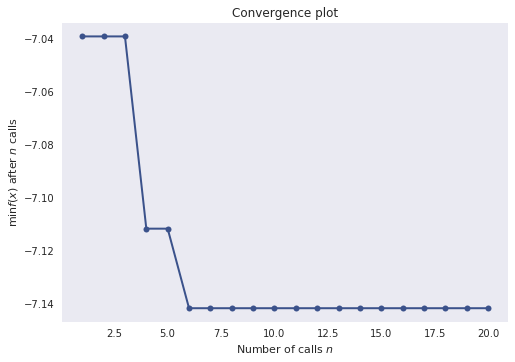

In [25]:
from skopt.plots import plot_convergence, plot_evaluations, plot_objective
plot_convergence(result)

In [26]:
bo_pol.theta

array([ 11.679,   0.486,   0.071,   0.442,   1.   ])

In [219]:
# np.save('high_stakes_3cents',bo_pol.theta)

In [27]:
a = datetime.datetime.now()
bo_utils = get_util(bo_pol, test_envs, parallel=Parallel(n_jobs=20),return_mean=False)
t = datetime.datetime.now() - a

In [28]:
np.mean(bo_utils)

7.1193556381263559

In [29]:
mg_pol = LiederPolicy([1, 1, 0, 0, 1])
a = datetime.datetime.now()
mg_utils = get_util(mg_pol, test_envs, parallel=Parallel(n_jobs=20),return_mean=False)
t = datetime.datetime.now() - a

In [30]:
np.mean(mg_utils)

7.2164397985038464

In [31]:
from scipy.stats import ttest_ind
ttest_ind(bo_utils,mg_utils)

Ttest_indResult(statistic=-0.34340012753570187, pvalue=0.73222134529588634)

In [32]:
from scipy.stats import ttest_rel
ttest_rel(bo_utils,mg_utils)

Ttest_relResult(statistic=-1.2061004963574689, pvalue=0.23504481889857098)

In [33]:
no_pol = FixedPlanPolicy([term_action])
a = datetime.datetime.now()
no_utils = get_util(no_pol, test_envs, parallel=Parallel(n_jobs=20),return_mean=False)
t = datetime.datetime.now() - a

In [34]:
np.mean(no_utils)

5.0

In [35]:
fo_pol = FixedPlanPolicy(range(term_action+1))
a = datetime.datetime.now()
fo_utils = get_util(fo_pol, test_envs, parallel=Parallel(n_jobs=20),return_mean=False)
t = datetime.datetime.now() - a

In [36]:
np.mean(fo_utils)

6.75839878191419

In [37]:
utils = [bo_utils,mg_utils,no_utils,fo_utils]
policies = ['bo','metagreedy','none','full-obs']
d_list = []
for u,p in zip(utils,policies):
    for result in u:
        d_list.append({'util':result,'stakes':'high','cost':0.03,'policy':p})

In [38]:
df = pd.DataFrame(d_list)
df

,cost,policy,stakes,util
0,0.03,bo,high,7.292699
1,0.03,bo,high,7.912315
2,0.03,bo,high,6.097723
3,0.03,bo,high,7.375388
4,0.03,bo,high,6.781878
5,0.03,bo,high,11.511568
6,0.03,bo,high,5.812373
7,0.03,bo,high,6.716564
8,0.03,bo,high,7.166972
9,0.03,bo,high,6.875504


In [39]:
df[df['policy'] == 'metagreedy'].util.mean()

7.216439798503847

In [234]:
# df.to_hdf('high_stakes_3cents_results','results')

In [42]:
df2 = pd.read_hdf('data/high_stakes_3cents_results','results')

In [43]:
df2[df2['policy']=='metagreedy'].util.mean()

7.4295954581247585

## High Stakes 0.5 cents

In [53]:
gambles = 7
attributes = 4
# reward = Normal(0,1)
# max_obs=30
high_stakes = Normal((9.99+0.01)/2, 0.3*(9.99-0.01))
low_stakes = Normal((0.25+0.01)/2, 0.3*(0.25-0.01))
reward = high_stakes
cost=.005

#set to 20 for sanity check
n_train = 250
n_test = 250

train_envs_hd = [OldMouselabEnv(gambles, hd_dist(attributes), reward, cost) for _ in range(n_train)]
train_envs_ld = [OldMouselabEnv(gambles, ld_dist(attributes), reward, cost) for _ in range(n_train)]
train_envs = train_envs_hd+train_envs_ld 

test_envs_hd =  [OldMouselabEnv(gambles, hd_dist(attributes), reward, cost) for _ in range(n_train)]
test_envs_ld = [OldMouselabEnv(gambles, ld_dist(attributes), reward, cost) for _ in range(n_train)]
test_envs = test_envs_hd+test_envs_ld 

term_action = train_envs[0].term_action

In [ ]:
a = datetime.datetime.now()
# bop2 = bo_policy(train_envs, max_cost=max_obs, n_jobs=20, n_calls=20, x0=[1., 1., 0., 0.])
bo_pol, result = bo_policy(train_envs, max_cost=30, n_jobs=50, n_calls=20, x0=[1., 1., 0., 0.],
                           verbose=1, normalize_voi=True, return_result=True)
t = datetime.datetime.now() - a
print(t)

[ 1.  1.  0.  0.  1.] -> 7.733 in 251 sec


In [ ]:
from skopt.plots import plot_convergence, plot_evaluations, plot_objective
plot_convergence(result)

In [ ]:
bo_pol.theta

In [ ]:
np.save('high_stakes_0.5cents',bo_pol.theta)

In [ ]:
a = datetime.datetime.now()
bo_utils = get_util(bo_pol, test_envs, parallel=Parallel(n_jobs=20),return_mean=False)
t = datetime.datetime.now() - a

In [ ]:
np.mean(bo_utils)

In [ ]:
mg_pol = LiederPolicy([1, 1, 0, 0, 1])
a = datetime.datetime.now()
mg_utils = get_util(mg_pol, test_envs, parallel=Parallel(n_jobs=20),return_mean=False)
t = datetime.datetime.now() - a

In [ ]:
np.mean(mg_utils)

In [ ]:
from scipy.stats import ttest_ind
ttest_ind(bo_utils,mg_utils)

In [ ]:
from scipy.stats import ttest_rel
ttest_rel(bo_utils,mg_utils)

In [ ]:
no_pol = FixedPlanPolicy([term_action])
a = datetime.datetime.now()
no_utils = get_util(no_pol, test_envs, parallel=Parallel(n_jobs=20),return_mean=False)
t = datetime.datetime.now() - a

In [ ]:
np.mean(no_utils)

In [ ]:
fo_pol = FixedPlanPolicy(range(term_action+1))
a = datetime.datetime.now()
fo_utils = get_util(fo_pol, test_envs, parallel=Parallel(n_jobs=20),return_mean=False)
t = datetime.datetime.now() - a

In [ ]:
np.mean(fo_utils)

In [ ]:
utils = [bo_utils,mg_utils,no_utils,fo_utils]
policies = ['bo','metagreedy','none','full-obs']
d_list = []
for u,p in zip(utils,policies):
    for result in u:
        d_list.append({'util':result,'stakes':'high','cost':cost,'policy':p})

In [ ]:
df = pd.DataFrame(d_list)
df

In [ ]:
df[df['policy'] == 'metagreedy'].util.mean()

In [ ]:
df.to_hdf('high_stakes_0.5cents_results','results')

In [ ]:
df2 = pd.read_hdf('high_stakes_3cents_results','results')

In [ ]:
df2[df2['policy']=='metagreedy'].util.mean()

# Scratch

## Old

In [159]:
# def run_params(gambles = 3, attributes = [0.25,0.74,0.01], reward = Normal(2,1), max_obs=30, cost=.01):
#     print(str(gambles)+' gambles, probs: '+ str(attributes) + ', cost:' + str(cost))
#     env = OldMouselabEnv(gambles, attributes,reward,cost)
#     train_envs = [env] * 100
#     term_action = train_envs[0].term_action
#     policies = {
# #         'BO': bo_policy(train_envs, max_cost=30, n_jobs=5, n_calls=250, 
# #                         verbose=0, normalize_voi=False),
#         'BO': bo_policy(train_envs, max_cost=max_obs, n_calls=10),
# #         'BO_unnorm': bo_policy(train_envs, max_cost=max_obs, normalize_voi=False, n_calls=350),
#         'meta-greedy': LiederPolicy([1, 1, 0, 0, 1]),
# #         'blinkered': blinkered_policy(env),
# #         'optimal': optimal_policy(env),
#         'full-observation': LiederPolicy([-100, 0.5, 0.5, 0, 1]),
#         'none': FixedPlanPolicy([term_action])
#     }
#     np.save('data/bo'+str(cost)+str(gambles), policies['BO'].theta)
    
#     def test():    
#         for name, policy in policies.items():
#             df = evaluate(policy, envs=test_envs)
#             df['agent'] = name
#             df['gambles'] = gambles
#             df['attr'] = str(attributes)
#             df['cost'] = cost
#             yield df
#     return pd.concat(test())

In [281]:
# policies = {
# #   'BO': bo_policy(train_envs, max_cost=30, n_jobs=5, n_calls=250, 
# #                         verbose=0, normalize_voi=False),
# #     'BO': bo_policy(train_envs, max_cost=max_obs, n_calls=10),
#     'meta-greedy': LiederPolicy([1, 1, 0, 0, 1]),
#     'full-observation': FixedPlanPolicy(range(term_action)),
#     'none': FixedPlanPolicy([term_action])
# }
# # np.save('data/bo'+str(cost)+str(gambles), policies['BO'].theta)
    
# def test(policies):   
#     test_envs = [env] * 20
#     for name, policy in policies.items():
#         df = evaluate(policy, envs=test_envs)
#         df['agent'] = name
#         df['gambles'] = gambles
#         df['attr'] = str(attributes)
#         df['cost'] = cost
#         return df
# df = pd.concat(test())

In [53]:
data = Parallel(n_jobs=20)(delayed(run_params)(cost=cost) for cost in np.logspace(-4, -1, 5))
store = pd.HDFStore('second_try.h5')
store['data'] = pd.concat(data)
store.close()

3 gambles, probs: [0.25, 0.74, 0.01], cost:0.0001
3 gambles, probs: [0.25, 0.74, 0.01], cost:0.00056234132519
3 gambles, probs: [0.25, 0.74, 0.01], cost:0.0177827941004
3 gambles, probs: [0.25, 0.74, 0.01], cost:0.00316227766017
3 gambles, probs: [0.25, 0.74, 0.01], cost:0.1
BO: [ 1.     0.389  0.214  0.397  1.   ] -> 2.492 in 2494 sec
BO: [ 3.498  0.57   0.43   0.     1.   ] -> 2.723 in 3319 sec
BO: [ 19.083   0.52    0.403   0.077   1.   ] -> 2.801 in 3842 sec
BO: [ 1.004  0.379  0.343  0.278  1.   ] -> 2.808 in 4446 sec
BO: [ 14.735   0.4     0.26    0.339   1.   ] -> 2.793 in 4769 sec


In [54]:
# df = pd.concat(data)
df = pd.read_hdf('second_try.h5','data')

In [55]:
df.groupby('cost agent'.split()).util.mean()

cost      agent           
0.000100  BO                  2.526308
          full-observation    2.736442
          meta-greedy         2.765520
          none                2.000000
0.000562  BO                  2.660385
          full-observation    2.868553
          meta-greedy         2.639586
          none                2.000000
0.003162  BO                  2.565508
          full-observation    2.473717
          meta-greedy         2.524450
          none                2.000000
0.017783  BO                  2.557559
          full-observation    2.429334
          meta-greedy         2.651951
          none                2.000000
0.100000  BO                  2.536742
          full-observation    1.985387
          meta-greedy         2.468443
          none                2.000000
Name: util, dtype: float64

/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


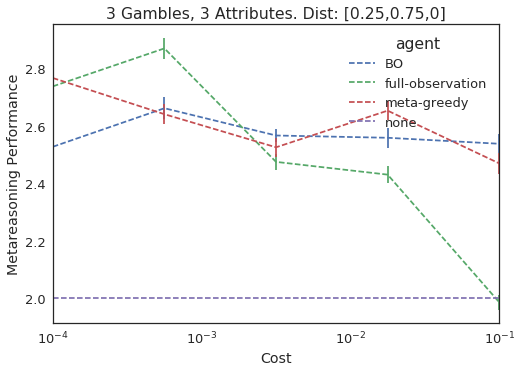

In [56]:
error = df.groupby('cost agent'.split()).util.std().unstack()*1.96/np.sqrt(1000)
(df
 .groupby('cost agent'.split())
 .util.mean().unstack()
 .plot(logx=True, ls='--',yerr=error, by='n_arm'))
# plt.xlim(10**-4.05,10**-0.95)
plt.ylabel('Metareasoning Performance')
plt.xlabel('Cost')
plt.title('3 Gambles, 3 Attributes. Dist: [0.25,0.75,0]')

In [58]:
data = Parallel(n_jobs=20)(delayed(run_params)(cost=cost) for cost in np.logspace(-4, -1, 5))
store = pd.HDFStore('second_try.h5')
store['data'] = pd.concat(data)
store.close()

3 gambles, probs: [0.25, 0.74, 0.01], cost:0.0001
3 gambles, probs: [0.25, 0.74, 0.01], cost:0.00056234132519
3 gambles, probs: [0.25, 0.74, 0.01], cost:0.00316227766017
3 gambles, probs: [0.25, 0.74, 0.01], cost:0.0177827941004
3 gambles, probs: [0.25, 0.74, 0.01], cost:0.1
BO: [ 4.071  0.339  0.133  0.528  1.   ] -> 2.241 in 397 sec
BO: [ 7.28   0.222  0.532  0.246  1.   ] -> 2.577 in 800 sec
BO: [ 19.083   0.52    0.403   0.077   1.   ] -> 2.801 in 1044 sec
BO: [ 12.391   0.459   0.185   0.356   1.   ] -> 2.728 in 1183 sec
BO: [ 14.735   0.4     0.26    0.339   1.   ] -> 2.793 in 1406 sec


/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


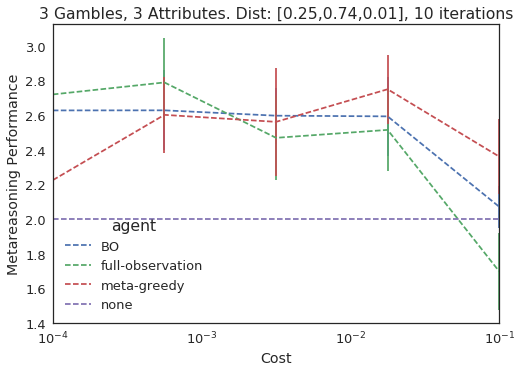

In [65]:
# df = pd.concat(data)
df = pd.read_hdf('second_try.h5','data')
error = df.groupby('cost agent'.split()).util.std().unstack()*1.96/np.sqrt(20)
(df
 .groupby('cost agent'.split())
 .util.mean().unstack()
 .plot(logx=True, ls='--',yerr=error, by='n_arm'))
# plt.xlim(10**-4.05,10**-0.95)
plt.ylabel('Metareasoning Performance')
plt.xlabel('Cost')
plt.title('3 Gambles, 3 Attributes. Dist: [0.25,0.74,0.01], 10 iterations')

## Unit Testing for Mouselab Environment

In [168]:
gambles = 4
attributes = [0.25,0.75,0,0]
reward = Normal(2,1)
env = OldMouselabEnv(gambles, attributes,reward)
env.reset()

array([Norm(2.00, 1.00), Norm(2.00, 1.00), Norm(2.00, 1.00), Norm(2.00, 1.00), Norm(2.00, 1.00), Norm(2.00, 1.00), Norm(2.00, 1.00), Norm(2.00, 1.00), Norm(2.00, 1.00), Norm(2.00, 1.00),
       Norm(2.00, 1.00), Norm(2.00, 1.00), Norm(2.00, 1.00), Norm(2.00, 1.00), Norm(2.00, 1.00), Norm(2.00, 1.00)], dtype=object)

In [169]:
env.vars

array([ 0.625,  0.625,  0.625,  0.625])

In [170]:
env.mus

[2.0, 2.0, 2.0, 2.0]

In [171]:
env.step(1)
env.step(5)
env.step(4)
env.step(4)

step 1
obs 1
step 5
obs 5
step 4
obs 4
step 4


((Norm(2.00, 1.00),
  1.0387309172247476,
  Norm(2.00, 1.00),
  Norm(2.00, 1.00),
  1.925737927437906,
  1.2992395552812623,
  Norm(2.00, 1.00),
  Norm(2.00, 1.00),
  Norm(2.00, 1.00),
  Norm(2.00, 1.00),
  Norm(2.00, 1.00),
  Norm(2.00, 1.00),
  Norm(2.00, 1.00),
  Norm(2.00, 1.00),
  Norm(2.00, 1.00),
  Norm(2.00, 1.00)),
 0,
 False,
 {})

In [172]:
env.vpi()

[Norm(1.28, 0.06) Norm(1.46, 0.00) Norm(2.00, 0.57) Norm(2.00, 0.57)]


0.32968609849781005

In [173]:
env.expected_term_reward()

bg [Norm(0.50, 0.06) Norm(1.50, 0.56) Norm(0.00, 0.00) Norm(0.00, 0.00)]


2.0

In [174]:
np.max(env.mus)

2.0

In [175]:
grid = np.array(env._state).reshape(env.gambles,env.outcomes)
print(grid)
print(env.mus)
print(env.vars)

[[Norm(2.00, 1.00) 1.0387309172247476 Norm(2.00, 1.00) Norm(2.00, 1.00)]
 [1.925737927437906 1.2992395552812623 Norm(2.00, 1.00) Norm(2.00, 1.00)]
 [Norm(2.00, 1.00) Norm(2.00, 1.00) Norm(2.00, 1.00) Norm(2.00, 1.00)]
 [Norm(2.00, 1.00) Norm(2.00, 1.00) Norm(2.00, 1.00) Norm(2.00, 1.00)]]
[1.2790481879185607, 1.4558641483204231, 2.0, 2.0]
[ 0.062  0.     0.625  0.625]


In [176]:
env.dist

array([ 0.25,  0.75,  0.  ,  0.  ])

In [177]:
grid

array([[Norm(2.00, 1.00), 1.0387309172247476, Norm(2.00, 1.00), Norm(2.00, 1.00)],
       [1.925737927437906, 1.2992395552812623, Norm(2.00, 1.00), Norm(2.00, 1.00)],
       [Norm(2.00, 1.00), Norm(2.00, 1.00), Norm(2.00, 1.00), Norm(2.00, 1.00)],
       [Norm(2.00, 1.00), Norm(2.00, 1.00), Norm(2.00, 1.00), Norm(2.00, 1.00)]], dtype=object)

In [178]:
np.sum(grid[1] * env.dist)

Norm(1.46, 0.00)

In [179]:
gambles = grid.dot(env.dist)
samples_max = np.amax([[gambles[i].sample() for i in range(env.gambles)] for _ in range(2500)],1)

In [180]:
gambles

array([Norm(1.28, 0.06), Norm(1.46, 0.00), Norm(2.00, 0.57), Norm(2.00, 0.57)], dtype=object)

In [181]:
env.gambles

4

In [182]:
import datetime

In [183]:
a = datetime.datetime.now()
means = []
for i in range(100):
    samples = [np.max([gambles[i].sample() for i in range(env.gambles)]) for i in range(2500)]
    means.append(np.mean(samples))
t = datetime.datetime.now() - a
print(np.mean(means))

2.32407956312


In [184]:
print(t)

0:00:05.027743


In [185]:
a = datetime.datetime.now()
means = []
for i in range(100):
    samples = np.amax([[gambles[i].sample() for i in range(env.gambles)] for _ in range(2500)],1)
    means.append(np.mean(samples))
t = datetime.datetime.now() - a
print(np.mean(means))

2.32389103332


In [186]:
print(t)

0:00:01.232662


In [187]:
gambles[1].sample()

1.4558641483204233

In [188]:
env.dist * grid[1]

array([0.4814344818594765, 0.9744296664609468, Norm(0.00, 0.00), Norm(0.00, 0.00)], dtype=object)

In [189]:
env.reset()
grid = np.array(env._state).reshape(env.gambles,env.outcomes)
env.dist * grid[1]

array([Norm(0.50, 0.06), Norm(1.50, 0.56), Norm(0.00, 0.00), Norm(0.00, 0.00)], dtype=object)

In [190]:
[expectation(np.sum(env.dist*grid[g])) for g in range(env.gambles)]

[2.0, 2.0, 2.0, 2.0]

In [191]:
best_gamble = env.best_gamble()

In [192]:
best_gamble[3]

Norm(2.00, 1.00)

In [193]:
np.sum(best_gamble).sample()

9.594203092044886

In [194]:
env.dist*grid[1]

array([Norm(0.50, 0.06), Norm(1.50, 0.56), Norm(0.00, 0.00), Norm(0.00, 0.00)], dtype=object)

In [195]:
env.expected_term_reward()

bg [Norm(0.50, 0.06) Norm(1.50, 0.56) Norm(0.00, 0.00) Norm(0.00, 0.00)]


2.0

## Training Trials

In [210]:
gambles = 4
attributes = [0.25,0.75,0,0]
reward = Normal(2,1)
env = OldMouselabEnv(gambles, attributes,reward)

In [211]:
len(env._state)

16

In [212]:
pol = LiederPolicy([1, 1, 0, 0, 1])

In [213]:
len(list(env.actions()))

17

In [214]:
env

In [215]:
agent = Agent()
def run_env(policy, env):
    agent.register(env)
    agent.register(policy)
    tr = agent.run_episode()
    return {'util': tr['return'],
            'observations': len(tr['actions']) - 1}
run_env(pol, env) 

/global/software/sl-6.x86_64/modules/langs/python/3.5.1/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1645: RuntimeWarning: divide by zero encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/global/software/sl-6.x86_64/modules/langs/python/3.5.1/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/global/software/sl-6.x86_64/modules/langs/python/3.5.1/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1728: RuntimeWarning: divide by zero encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)


{'observations': 16, 'util': 3.225274770852804}

In [216]:
def run_params(gambles = 3, attributes = [0.25,0.75,0], reward = Normal(2,1), max_obs=30, cost=.01):
    print(str(gambles)+' gambles, probs: '+ str(attributes) + ', cost:' + str(cost))
    env = OldMouselabEnv(gambles, attributes,reward)
    train_envs = [env] * 1
    term_action = train_envs[0].term_action
    policies = {
#         'BO': bo_policy(train_envs, max_cost=30, n_jobs=5, n_calls=250, 
#                         verbose=0, normalize_voi=False),
#         'BO': bo_policy(train_envs, max_cost=max_obs, n_calls=150),
#         'BO_unnorm': bo_policy(train_envs, max_cost=max_obs, normalize_voi=False, n_calls=350),
        'meta-greedy': LiederPolicy([1, 1, 0, 0, 1]),
#         'blinkered': blinkered_policy(env),
#         'optimal': optimal_policy(env),
        'full-observation': LiederPolicy([-100, 0.5, 0.5, 0, 1]),
        'none': FixedPlanPolicy([term_action])
    }
    test_envs = [env] * 20
    def test():    
        for name, policy in policies.items()
            df = evaluate(policy, envs=test_envs)
            df['agent'] = name
            df['gambles'] = gambles
            df['attr'] = str(attributes)
            df['cost'] = cost
            yield df
    return pd.concat(test())

In [219]:
data = Parallel(n_jobs=7)(delayed(run_params)(cost=cost) for cost in np.logspace(-4, -1, 7))
store = pd.HDFStore('first_try.h5')
store['data'] = pd.concat(data)
store.close()

3 gambles. probs: [0.25, 0.75, 0]
3 gambles. probs: [0.25, 0.75, 0]
3 gambles. probs: [0.25, 0.75, 0]
3 gambles. probs: [0.25, 0.75, 0]
3 gambles. probs: [0.25, 0.75, 0]
3 gambles. probs: [0.25, 0.75, 0]
3 gambles. probs: [0.25, 0.75, 0]


/global/software/sl-6.x86_64/modules/langs/python/3.5.1/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1645: RuntimeWarning: divide by zero encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/global/software/sl-6.x86_64/modules/langs/python/3.5.1/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1645: RuntimeWarning: divide by zero encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/global/software/sl-6.x86_64/modules/langs/python/3.5.1/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1645: RuntimeWarning: divide by zero encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/global/software/sl-6.x86_64/modules/langs/python/3.5.1/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn

KeyboardInterrupt: 